In [1]:
import torch
import torch.nn as nn
import torchvision
from torchinfo import summary         
import numpy as np
import torchvision.transforms as tf
import transformers                    
from tensorboardX import SummaryWriter 
from pkg_resources import packaging    
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from openTSNE import TSNE              
import pandas as pd
import seaborn as sns

import torchvision.models as models
from torch.optim import Adam
import torch.nn.functional as F

from tqdm import tqdm
import random
import re
import time
import math

c:\Users\sunsh\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


set seed

In [2]:
seed = 2023
random.seed(seed)  
np.random.seed(seed)  
torch.manual_seed(seed) 
torch.cuda.manual_seed(seed)  
torch.cuda.manual_seed_all(seed) 
torch.backends.cudnn.benchmark = False  
torch.backends.cudnn.deterministic = True  

In [3]:
# Import packages
import os,sys,humanize,psutil,GPUtil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

load model and data

In [4]:
# classification_model = torch.load('model_classification_resnet50.pth')
# latent_code_model = torch.nn.Sequential(*list(classification_model.children())[:-1])

# def freeze_backbone(model):
#     for k,v in model.named_parameters():
#         v.requires_grad = False

# freeze_backbone(latent_code_model)
# torch.save(latent_code_model, 'model_classification_resnet50_withoutfc.pth')

In [5]:
latent_code_model = torch.load('model_classification_resnet50_withoutfc.pth')
summary(latent_code_model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  (4,096)
│    │    └─BatchNorm2d: 3-2             (128)
│    │    └─Conv2d: 3-3                  (36,864)
│    │    └─BatchNorm2d: 3-4             (128)
│    │    └─Conv2d: 3-5                  (16,384)
│    │    └─BatchNorm2d: 3-6             (512)
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              (16,896)
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  (16,384)
│    │    └─BatchNorm2d: 3-10            (128)
│    │    └─Conv2d: 3-11                 (36,864)
│    │    └─BatchNorm2d: 3-12            (128)
│    │    └─C

In [6]:
simple_tf = tf.Compose([
    tf.PILToTensor(),
    tf.ConvertImageDtype(torch.float),
    tf.Resize((224, 224)),#, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_tf = tf.Compose([
    tf.PILToTensor(),
    tf.ConvertImageDtype(torch.float),
    tf.RandomHorizontalFlip(),
    tf.Resize((224, 224)),#, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    tf.RandomErasing(),
    tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

reverted_tf = tf.Compose([
    tf.Normalize((-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225), (1 / 0.229, 1 / 0.224, 1 / 0.225)),
    tf.Normalize((0, 0, 0), (1, 1, 1)),  # Unnormalize the tensor
    tf.ConvertImageDtype(torch.uint8),
    tf.ToPILImage(),
])

In [7]:
train_set = torchvision.datasets.CIFAR10("./data", train=True, download=True)
test_set = torchvision.datasets.CIFAR10("./data", train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_set = torchvision.datasets.CIFAR10("./data", train=True, download=False, transform=train_tf)
test_set = torchvision.datasets.CIFAR10("./data", train=False, download=False, transform=simple_tf)

In [9]:
batch_size = 64
device = torch.device('cuda')
max_epochs = 20
lr = 5e-6
weight_decay = 0.05
num_warmup_steps = 3 * math.ceil(len(train_set) / batch_size)
num_training_steps = max_epochs * math.ceil(len(train_set) / batch_size)
lr_decay_factor = .75
filter_bias_and_bn = True
optim_name = 'adam'
log_lr = True
only_train_fc = False
logger_name = "ResNet-50_v1"

reconstrct

In [10]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

def reconstruct_image(latent_coord, model, initial_img=None, img_size=(3, 224, 224), weights=[1, 1, 0.01], num_iterations=5000):

    if not initial_img:
        initial_img = torch.randn(img_size)
        normalize = tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        initial_img = normalize(initial_img)
    initial_img = initial_img.to(device).unsqueeze(0)
    initial_img.requires_grad_(True)

    for param in model.parameters():
        param.requires_grad = False

    # Set up the optimizer
    optimizer = Adam([initial_img], lr=0.01, weight_decay=weights[-1])

    # Optimization loop
    losses, latent_losses, tv_losses = [], [], []
    for i in range(num_iterations):

        latent_output = model(initial_img)
        latent_loss = torch.mean((latent_output - latent_coord) ** 2)
        total_variation_loss = tv_loss(initial_img)
        # l6_normalized = torch.pow(initial_img, 6).sum()
        loss = weights[0] * latent_loss + weights[1] * total_variation_loss
        latent_losses.append(latent_loss)
        tv_losses.append(total_variation_loss)
        losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 500 == 0:
            print(i)

        if loss < 0.01:
            break

    optimized_img = initial_img.squeeze()
    return optimized_img, losses, latent_losses, tv_losses

`index` is the index of image in `test_set`.

`decay` is the l2 norm weight.

In [55]:
def eval_reconstrcut(index, tv_weight, decay=0):
    latent_coord = latent_code_model(test_set[index][0].to(device).unsqueeze(0))
    img = reconstruct_image(latent_coord, latent_code_model, weights=[1, tv_weight, decay])

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(reverted_tf(test_set[index][0]))
    plt.axis('off')
    plt.title('Dog')

    plt.subplot(1, 2, 2)
    plt.imshow(reverted_tf(img[0]))
    plt.axis('off')
    plt.title('Dog')

    return img

0
500
1000
1500
2000
2500
3000
3500
4000
4500


Text(0.5, 1.0, 'tv')

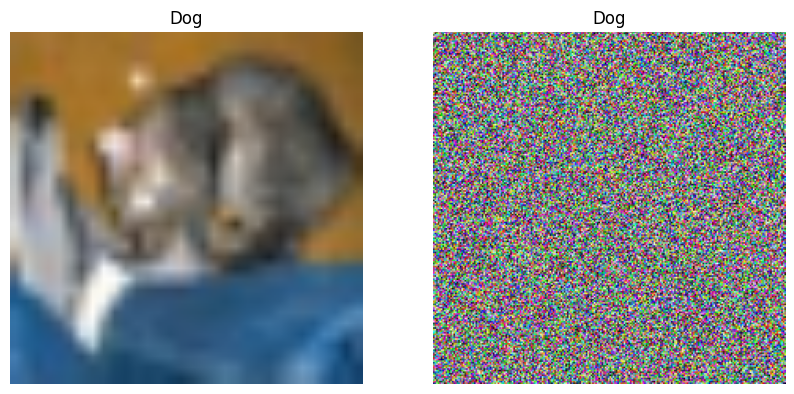

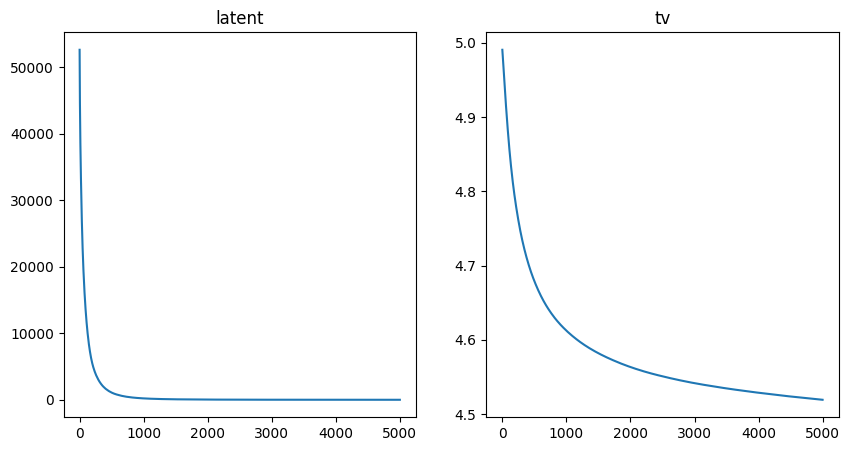

In [12]:
img1, losses1, latent_losses1, tv_losses1 = eval_reconstrcut(0, 0)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot([tensor.cpu().detach().numpy() for tensor in latent_losses1])
plt.title('latent')

plt.subplot(1, 2, 2)
plt.plot([tensor.cpu().detach().numpy() for tensor in tv_losses1])
plt.title('tv')

0
500
1000
1500
2000
2500
3000
3500
4000
4500


Text(0.5, 1.0, 'tv')

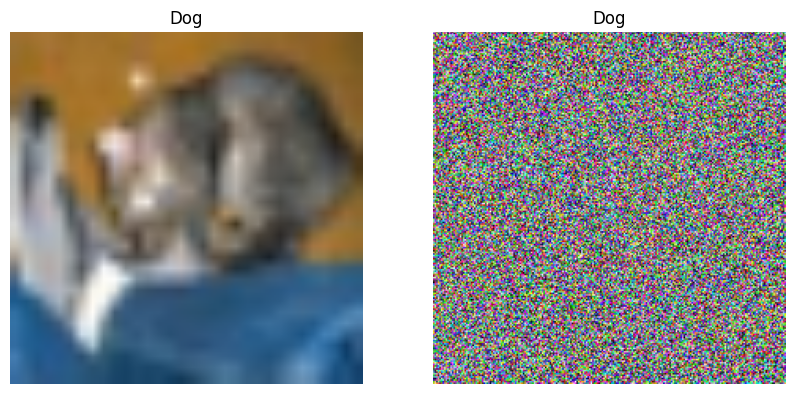

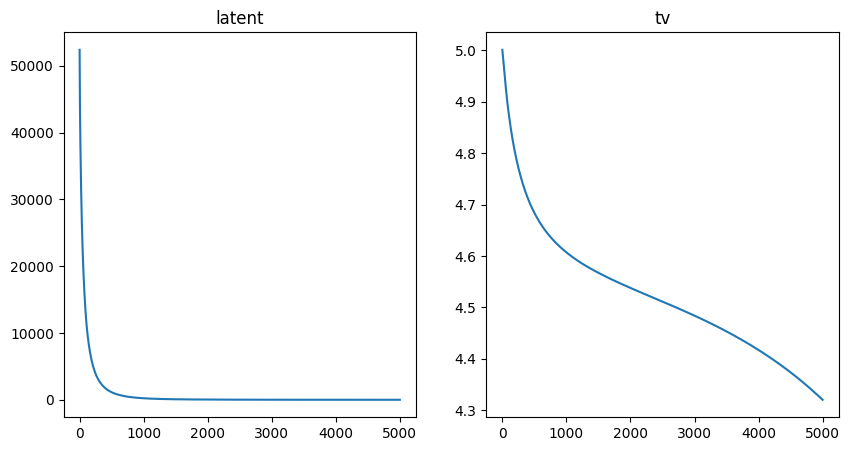

In [13]:
img2, losses2, latent_losses2, tv_losses2 = eval_reconstrcut(0, 10)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot([tensor.cpu().detach().numpy() for tensor in latent_losses2])
plt.title('latent')

plt.subplot(1, 2, 2)
plt.plot([tensor.cpu().detach().numpy() for tensor in tv_losses2])
plt.title('tv')

0
500
1000
1500
2000
2500
3000
3500
4000
4500


Text(0.5, 1.0, 'tv')

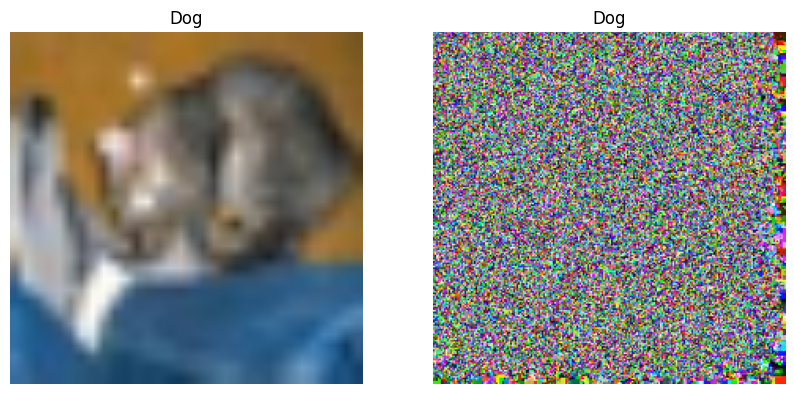

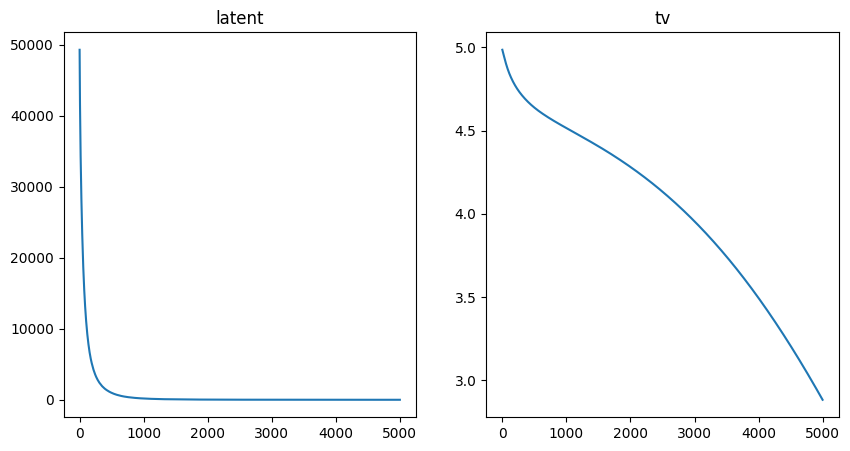

In [14]:
img3, losses3, latent_losses3, tv_losses3 = eval_reconstrcut(0, 100)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot([tensor.cpu().detach().numpy() for tensor in latent_losses3])
plt.title('latent')

plt.subplot(1, 2, 2)
plt.plot([tensor.cpu().detach().numpy() for tensor in tv_losses3])
plt.title('tv')

0
500
1000
1500
2000
2500
3000
3500
4000
4500


Text(0.5, 1.0, 'tv')

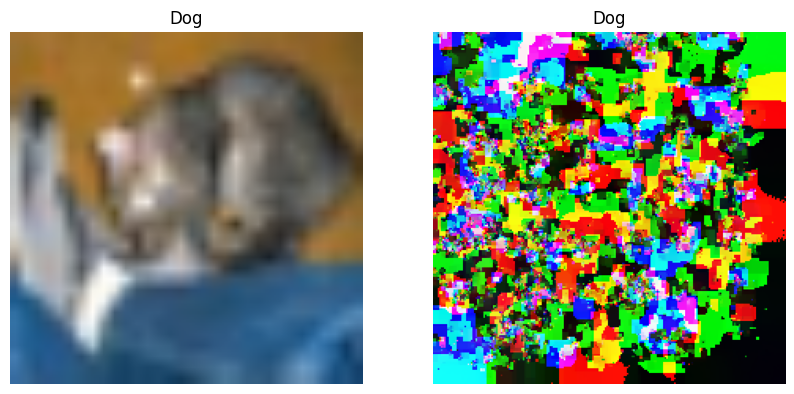

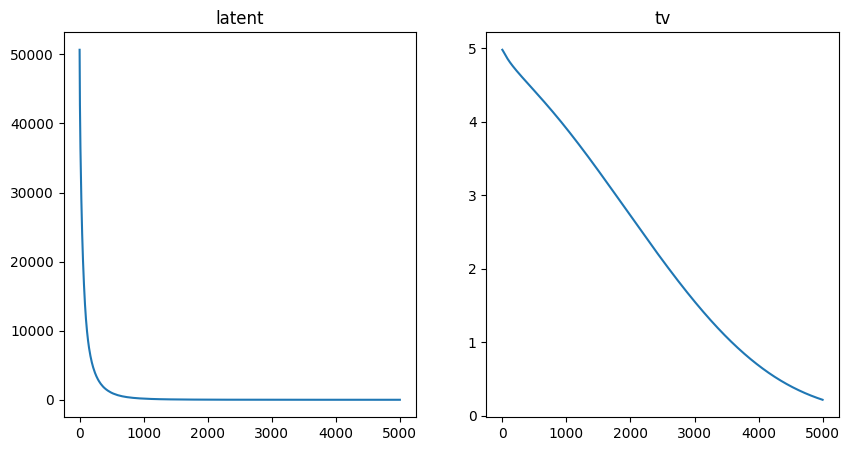

In [15]:
img4, losses4, latent_losses4, tv_losses4 = eval_reconstrcut(0, 1000)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot([tensor.cpu().detach().numpy() for tensor in latent_losses4])
plt.title('latent')

plt.subplot(1, 2, 2)
plt.plot([tensor.cpu().detach().numpy() for tensor in tv_losses4])
plt.title('tv')

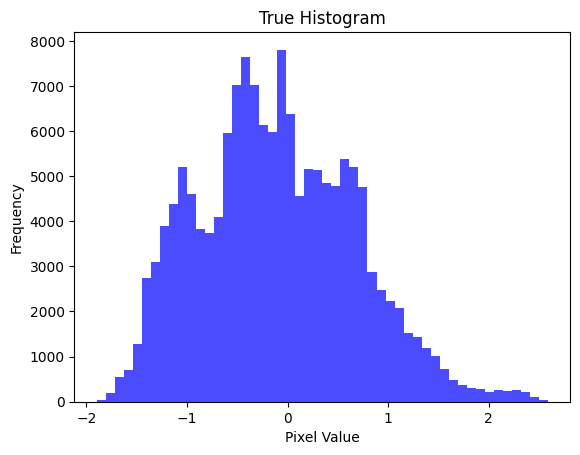

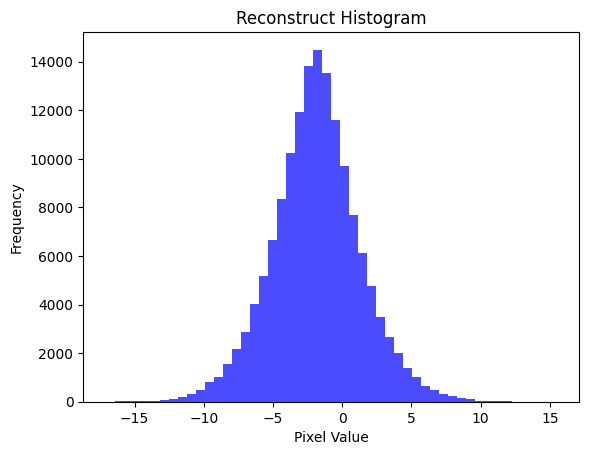

In [16]:
import torch
import matplotlib.pyplot as plt

# Create a tensor of shape 3*224*224 (replace this with your actual tensor)
tensor = test_set[0][0].clone()

# Flatten the tensor to a 1D array
flattened_tensor = tensor.view(-1)

# Convert the tensor to a numpy array
numpy_array = flattened_tensor.numpy()

# Create a histogram
plt.hist(numpy_array, bins=50, alpha=0.7, color='blue')
plt.title("True Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

# Create a tensor of shape 3*224*224 (replace this with your actual tensor)
tensor = img3.clone()

# Flatten the tensor to a 1D array
flattened_tensor = tensor.view(-1)

# Convert the tensor to a numpy array
numpy_array = flattened_tensor.cpu().detach().numpy()

# Create a histogram
plt.hist(numpy_array, bins=50, alpha=0.7, color='blue')
plt.title("Reconstruct Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

0
500
1000
1500
2000
2500
3000
3500
4000
4500


Text(0.5, 1.0, 'tv')

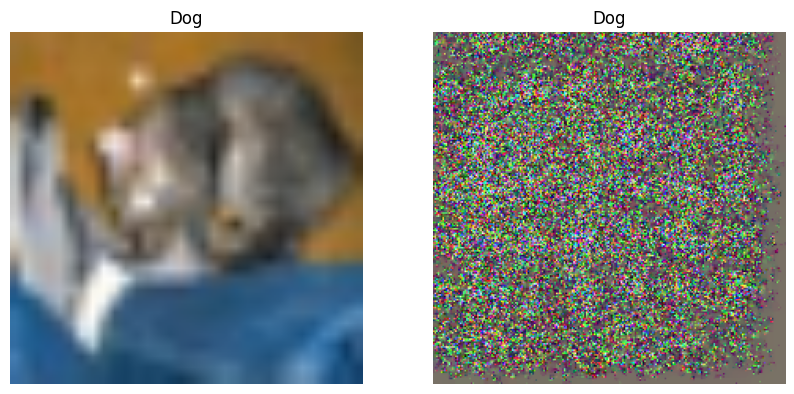

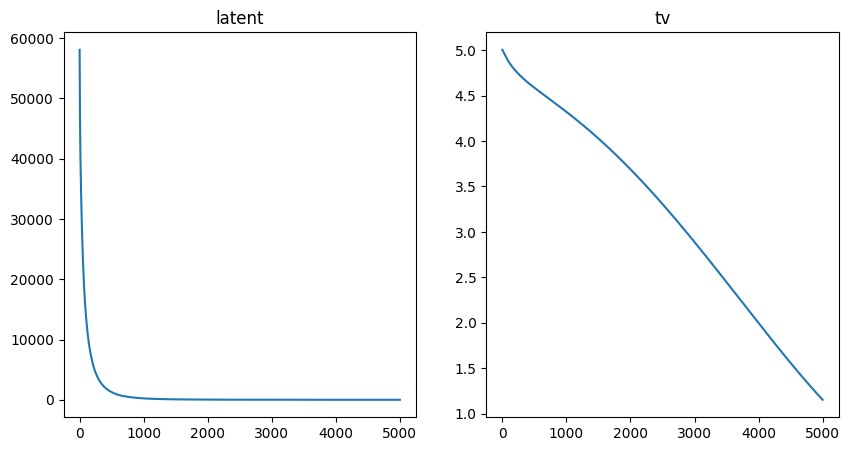

In [17]:
img5, losses5, latent_losses5, tv_losses5 = eval_reconstrcut(0, 100, decay=0.001)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot([tensor.cpu().detach().numpy() for tensor in latent_losses5])
plt.title('latent')

plt.subplot(1, 2, 2)
plt.plot([tensor.cpu().detach().numpy() for tensor in tv_losses5])
plt.title('tv')

0
500
1000
1500
2000
2500
3000
3500
4000
4500


Text(0.5, 1.0, 'tv')

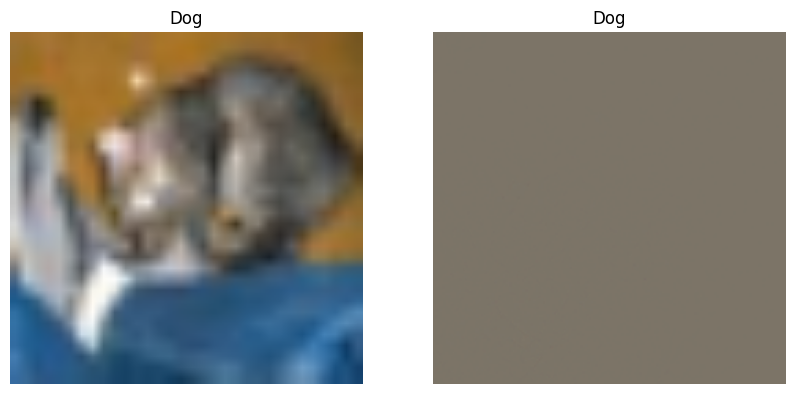

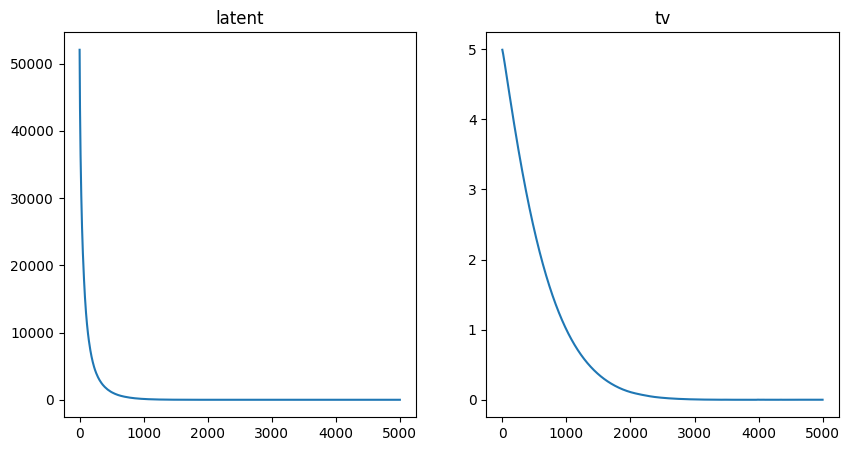

In [18]:
img6, losses6, latent_losses6, tv_losses6 = eval_reconstrcut(0, 100, decay=0.1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot([tensor.cpu().detach().numpy() for tensor in latent_losses6])
plt.title('latent')

plt.subplot(1, 2, 2)
plt.plot([tensor.cpu().detach().numpy() for tensor in tv_losses6])
plt.title('tv')

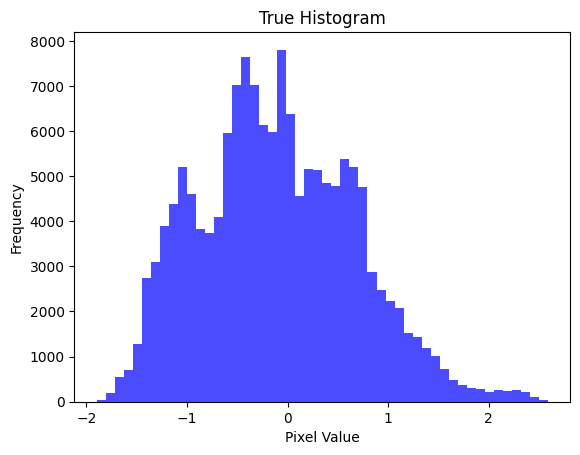

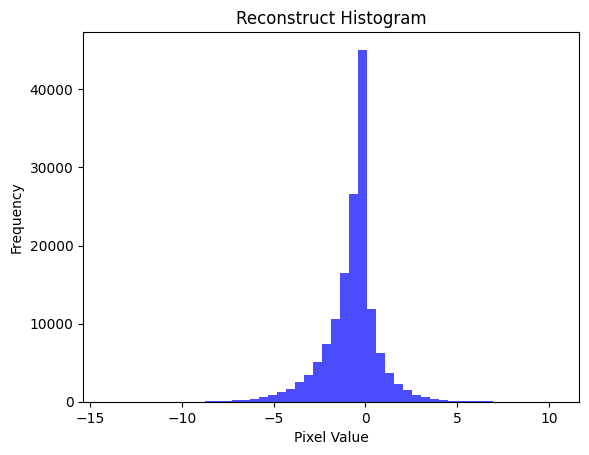

In [22]:
import torch
import matplotlib.pyplot as plt

# Create a tensor of shape 3*224*224 (replace this with your actual tensor)
tensor = test_set[0][0].clone()

# Flatten the tensor to a 1D array
flattened_tensor = tensor.view(-1)

# Convert the tensor to a numpy array
numpy_array = flattened_tensor.numpy()

# Create a histogram
plt.hist(numpy_array, bins=50, alpha=0.7, color='blue')
plt.title("True Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

# Create a tensor of shape 3*224*224 (replace this with your actual tensor)
tensor = img5.clone()

# Flatten the tensor to a 1D array
flattened_tensor = tensor.view(-1)

# Convert the tensor to a numpy array
numpy_array = flattened_tensor.cpu().detach().numpy()

# Create a histogram
plt.hist(numpy_array, bins=50, alpha=0.7, color='blue')
plt.title("Reconstruct Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

In [43]:
latent_code_model2 = torch.nn.Sequential(*list(latent_code_model.children())[:-4])
summary(latent_code_model2)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  (4,096)
│    │    └─BatchNorm2d: 3-2             (128)
│    │    └─Conv2d: 3-3                  (36,864)
│    │    └─BatchNorm2d: 3-4             (128)
│    │    └─Conv2d: 3-5                  (16,384)
│    │    └─BatchNorm2d: 3-6             (512)
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              (16,896)
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  (16,384)
│    │    └─BatchNorm2d: 3-10            (128)
│    │    └─Conv2d: 3-11                 (36,864)
│    │    └─BatchNorm2d: 3-12            (128)
│    │    └─C

In [44]:
def eval_reconstrcut(index, tv_weight, decay=0):
    latent_coord = latent_code_model2(test_set[index][0].to(device).unsqueeze(0))
    img = reconstruct_image(latent_coord, latent_code_model2, weights=[1, tv_weight, decay])

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(reverted_tf(test_set[index][0]))
    plt.axis('off')
    plt.title('Dog')

    plt.subplot(1, 2, 2)
    plt.imshow(reverted_tf(img[0]))
    plt.axis('off')
    plt.title('Dog')

    return img

0
500
1000
1500
2000
2500
3000
3500
4000
4500


Text(0.5, 1.0, 'tv')

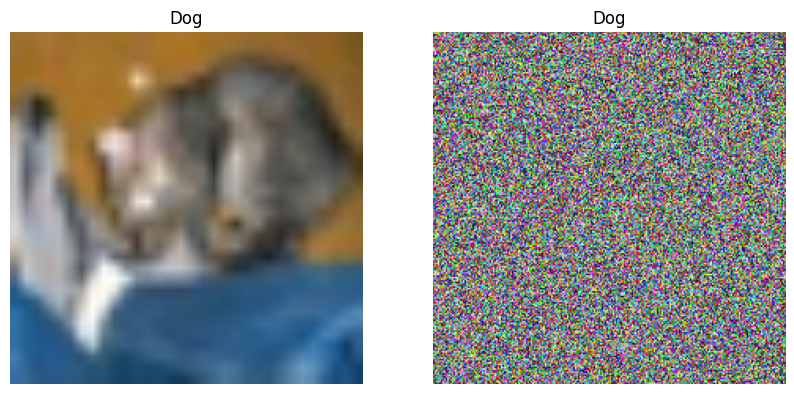

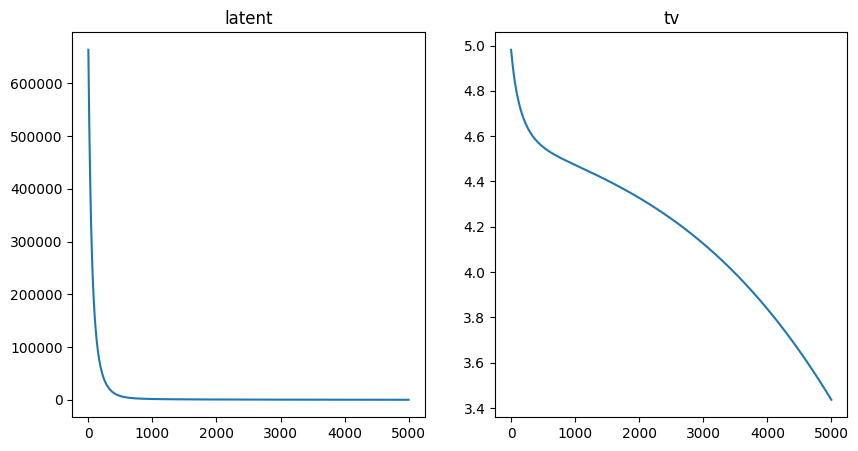

In [47]:
img7, losses7, latent_losses7, tv_losses7 = eval_reconstrcut(0, 100, decay=0.001)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot([tensor.cpu().detach().numpy() for tensor in latent_losses7])
plt.title('latent')

plt.subplot(1, 2, 2)
plt.plot([tensor.cpu().detach().numpy() for tensor in tv_losses7])
plt.title('tv')